In [2]:
%matplotlib inline
import warnings

warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import mdtraj as md

In [3]:
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt


## Load and inspect the data

In [12]:
traj = md.load('data/traj_3.xtc',top= 'data/water_top.pdb')
dt = traj.timestep
traj = md.compute_center_of_mass(traj)
traj.shape

(10000001, 3)

In [13]:
# df = pd.DataFrame(com, columns=['1', '2', '3'])
# df['t'] = traj.time/1000

# df_melt = pd.melt(frame=df, id_vars=['t'], value_vars=['1', '2', '3'], var_name='coord', )

# df_melt.head()

In [14]:
# g = sns.FacetGrid(df_melt.iloc[::100,:], col='coord')
# g.map(plt.scatter, 't', 'value', alpha=0.5, s=1)
# g.set_axis_labels('time (ns)', 'position (nm)')

Text(0.5, 0, 'z')

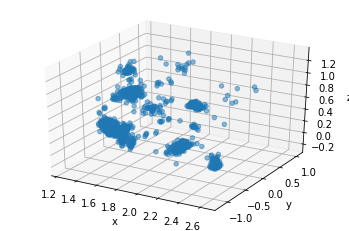

In [30]:
stride=5000
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter(xs=traj[::stride,0], ys=traj[::stride,1], zs=traj[::stride,2], alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')

## Split data into 1ns pieces

This is because we have a wide variety of behaviour across the trajectory and we only want to focus on small chunks at a time. 

In [18]:
window = 1000 # window size in ps
n_frames = int(window/dt) # number of frames in a window
n_splits = traj.shape[0]//n_frames # number of windows in trajectory
traj_split = np.array_split(traj, n_splits) # the split up 

## Set MSM parameters


In [20]:
msm_lag = int(10/dt)
tica_lag = int(5/dt)
n_clusters = int(np.sqrt(n_frames))

## Fit models

In [24]:
# Fit tica and get tica trajs
tica_objs = [coor.tica(traj, lag=tica_lag, dim=3,  kinetic_map=True) for traj in traj_split]
tica_trajs = [x.get_output() for x in tica_objs]

# Cluster using kmeans
dtraj_objs = [coor.cluster_kmeans(trajs, k=n_clusters, max_iter=100) for trajs in tica_trajs]


NameError: name 'dtraj_obs' is not defined

In [25]:
# Extract dtrajs
dtrajs = [x.dtrajs for x in dtraj_objs]

# get implied timescale plots
msms = [msm.estimate_markov_model(dtraj, lag=msm_lag) for dtraj in dtrajs]

In [88]:
hmms = [(i, mm.coarse_grain(2)) for i, mm in enumerate(msms) if mm.timescales()[0]/mm.timescales()[1]>1.5]

In [89]:
# If one of the lifetimes is infinity, that means there's an absorbing state so there's no oscilation
absorbing = [(i, np.any(np.abs(hmm.lifetimes)==np.inf)) for (i, hmm) in hmms]

## Plot results

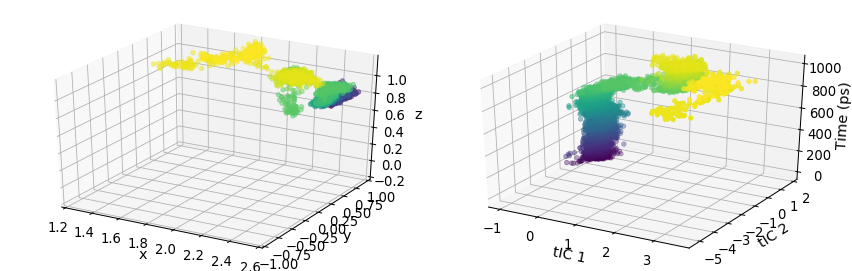

In [72]:
with sns.plotting_context('paper', font_scale=1.5):
    idx = 0
    stride=1
    fig = plt.figure(figsize=(18, 4))
    # Positions
    ax = fig.add_subplot(1,3,1,projection='3d')
    ax.scatter(xs=traj_split[idx][::stride,0], ys=traj_split[idx][::stride,1], 
               zs=traj_split[idx][::stride,2], alpha=0.5, c=np.arange(traj_split[idx].shape[0]))
    ax.set_xlim(1.2,2.6); ax.set_ylim(-1, 1); ax.set_zlim(-0.2, 1.2)
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')

    # TICA time trace
    ax = fig.add_subplot(1,3,2,projection='3d')
    ax.scatter(tica_trajs[idx][0][::stride, 0], tica_trajs[idx][0][::stride, 1], 
               np.arange(traj_split[idx].shape[0])*dt, c=np.arange(traj_split[idx].shape[0]))
    ax.set_xlabel('tIC 1'); ax.set_ylabel('tIC 2'); ax.set_zlabel('Time (ps)')

    plt.tight_layout()

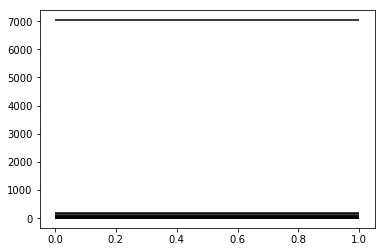

In [73]:
mm = msms[idx]
ts = mm.timescales()
plt.hlines(ts, 0, 1)

In [82]:
hmm = mm.coarse_grain(2)
~np.any(np.abs(hmm.lifetimes)==np.inf)

False

In [92]:
import dill
dill.dump_session('msm_whole_trajectories.db')